### **전체 과정...**
1. 예술영화와 일반영화 코퍼스에서 대표 단어를 뽑아 임베딩 공간의 기준 축을 만든다.
2. 각 영화 장르 코퍼스에서도 대표 단어를 뽑아 임베딩 벡터로 변환한다.
3. WEAT를 이용해 각 장르가 예술영화 쪽과 일반영화 쪽 중 어디에 더 가까운지 계산한다.
4. 이를 통해 영화 장르가 언어적으로 어떤 영화 유형에 더 편향되어 인식되는지 정량적으로 분석한다.

In [1]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.6.0
4.4.0
1.8.0
0.13.2


## (1) 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [2]:
import os

data_dir = os.path.join(os.getenv("HOME"), "work/weat/data")
file_name = os.path.join(data_dir, "synopsis.txt")

with open(file_name, 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [3]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt

okt = Okt()
tokenized = []

with open(file_name, 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다.
        tokenized.append(res)

print("슝~")

슝~


In [4]:
print(len(tokenized))

71156


In [5]:
print(tokenized[0])

['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분']


## 프로젝트 제출 루브릭 1
#### **[학습목표]** 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.
#### **[평가기준]** 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.
--------

## (2) 추출된 결과로 embedding model 만들기

In [6]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다.
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)
# model.most_similar(positive=['영화'])

[('작품', 0.8853482604026794),
 ('다큐멘터리', 0.8445157408714294),
 ('드라마', 0.8186449408531189),
 ('영화로', 0.7955385446548462),
 ('코미디', 0.7798371315002441),
 ('형식', 0.7796232104301453),
 ('소재', 0.7753269672393799),
 ('스토리', 0.7739407420158386),
 ('감동', 0.7733522653579712),
 ('영상', 0.7651779055595398)]

## (3) TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기

In [7]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

data_dir = os.path.join(os.getenv("HOME"), "work/weat/data")
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(data_dir + '/' + file_name, 'r') as fread:
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline()
            if not line: break
            tokenlist = okt.pos(line, stem=True, norm=True)
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0]))
    return ' '.join(result)

print("슝~")

슝~


In [8]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다.
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [9]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [10]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names_out()[23976])

23976
영화


In [11]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다.
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다.

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다.
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다.

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w1[i][0]], end=', ')

print('\n')

print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 시간, 다시, 아들, 소녀, 아내, 다른, 영화제, 사이, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 아빠, 생활, 통해, 모습, 기억, 죽음, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 결혼, 사고, 전쟁, 위기, 때문, 이제, 최고, 이자, 과거, 일상, 경찰, 간다, 상황, 미국, 운명, 결심, 관계, 현실, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 만난, 감정, 처음, 국제, 누구, 살인, 충격, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 의도, 동생, 하루, 위기, 계획, 정체, 한국, 

## 프로젝트 제출 루브릭 2
#### **[학습목표]** 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.
#### **[평가기준]** 타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.
-------

- **(AS-IS) TF-IDF가 생성하는 상위 단어 순서**
  1. 단순 문자열 차집합
  2. 앞에서부터 n개 채우기 (15개 제한)
  3. 대표 단어 셋 완성

<br>

- **문제점**
  1. 의미적 중복을 제거하지 않음
     - 예를 들어, movie / film / cinema 같은 단어가 동시에 들어올 수 있음
     - 같은 축 방향을 여러 번 반복해서 WEAT 분모가 약해짐
  2. TF-IDF 순위만 신뢰
     - “개념을 대표하는 단어”가 아니라 “그 문서에서만 자주 나온 단어”가 섞일 가능성 큼
  3. 다양성 제어가 없음
     - 전부 감정 단어, 전부 형용사, 전부 장르 단어 같은 현상 가능

-> 기존 방식은 형태나 의미가 매우 유사한 단어들이 동시에 포함될 가능성이 있으며, 개념축을 충분히 다양하게 반영하지 못함
    
<br>

- **(TO-BE) TF-IDF를 쓰되, 중복 단어를 제거**
  - cosine simility를 사용해 이미 선택된 단어들과 의미적으로 가까운 단어는 제거하는 과정을 추가

In [12]:
# 코드 추가

from numpy import dot
from numpy.linalg import norm

def cosine_sim(v1, v2):
    return dot(v1, v2) / (norm(v1) * norm(v2))


def is_similar_to_existing_words(word, selected_words, model, threshold=0.9):
    """
    word: 지금 새로 넣으려는 단어 (str)
    selected_words: 이미 뽑힌 대표 단어 리스트 (list[str])
    model: Word2Vec
    threshold: cosine similarity 기준값
    """
    if len(selected_words) == 0:
        return False  # 처음 단어는 무조건 허용
    
    w_vec = model.wv[word]

    for s in selected_words:
        s_vec = model.wv[s]
        sim = cosine_sim(w_vec, s_vec)
        if sim >= threshold:
            return True   # 이미 있는 단어와 너무 비슷 → 중복
    return False          # 충분히 다름 → 사용 가능

In [31]:
# 수정 코드

n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
## 예술영화 대표 단어
target_art_no_rep, target_gen_no_rep = [], []
for i in range(100):
    if (
        w1_[i] not in w2_
        and w1_[i] in model.wv
        and not is_similar_to_existing_words(w1_[i], target_art_no_rep, model, threshold=0.80)  # 추가
    ): 
        target_art_no_rep.append(w1_[i])
            
    if len(target_art_no_rep) == n:
        break

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
## 일반영화 대표 단어
for i in range(100):
    word = w2_[i]
    if (
        word not in w1_
        and word in model.wv
        and not is_similar_to_existing_words(w2_[i], target_gen_no_rep, model, threshold=0.80)  # 추가
    ):
        target_gen_no_rep.append(w2_[i])
    if len(target_gen_no_rep) == n:
        break

In [32]:
# 기존 코드

n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [33]:
print(target_art)
print(target_art_no_rep)

['결말', '존엄성', '억지', '의치', '젠스', '마술피리', '감언이설', '진국', '녹색혁명', '철곤', '그래퍼']
['결말', '존엄성', '억지', '의치', '젠스', '마술피리']


In [34]:
print(target_gen)
print(target_gen_no_rep)

['새신랑', '아테나', '어쩌다가', '가족', '제스처', '에세이', '삐라', '다르덴', '보장', '유람선', '계약서']
['새신랑', '아테나', '어쩌다가', '가족', '제스처', '에세이', '다르덴']


In [35]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt',
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt',
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt',
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt',
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [36]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [37]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [38]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names_out()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names_out()[w[i][j][0]])
            print(vectorizer.get_feature_names_out()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 국제, 마을, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 프롤, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 아이, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 사람, 운명, 최고, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 태구, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 시

## (4) embedding model과 단어 셋으로 WEAT score 구해보기

### WEAT 구현하기

In [39]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [40]:
# s('장미', A, B) 를 계산

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))
# norm(x) : 벡터 x의 크기(길이)\

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

In [41]:
# WEAT score의 수식

def weat_score(X, Y, A, B):

    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)

    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))

    return  (mean_X-mean_Y)/std_dev

### WEAT score 구해보기

In [42]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
matrix_no_rep = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
print("슝~")

슝~


In [43]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

print("슝~")

슝~


In [44]:
X = np.array([model.wv[word] for word in target_art_no_rep])
Y = np.array([model.wv[word] for word in target_gen_no_rep])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix_no_rep[i][j] = weat_score(X, Y, A, B)

print("슝~")

슝~


In [45]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 0.57221204
SF 공연 0.34479046
SF 공포(호러) 0.51826036
SF 기타 0.29588863
SF 다큐멘터리 0.4989533
SF 드라마 0.61887234
SF 멜로로맨스 0.5741268
SF 뮤지컬 0.2772334
SF 미스터리 0.5108527
SF 범죄 0.40473005
SF 사극 0.56194884
SF 서부극(웨스턴) 0.52679694
SF 성인물(에로) 0.49045575
SF 스릴러 0.514649
SF 애니메이션 0.40467283
SF 액션 0.5547203
SF 어드벤처 0.6133324
SF 전쟁 0.12648407
SF 코미디 0.64546293
SF 판타지 0.70960647
가족 공연 -0.4550524
가족 공포(호러) -0.3838169
가족 기타 -0.47757238
가족 다큐멘터리 -0.41808304
가족 드라마 -0.4683851
가족 멜로로맨스 -0.41107905
가족 뮤지컬 -0.39015502
가족 미스터리 -0.4015467
가족 범죄 -0.6201735
가족 사극 -0.5276005
가족 서부극(웨스턴) -0.37678766
가족 성인물(에로) -0.49209368
가족 스릴러 -0.55615455
가족 애니메이션 -0.49468532
가족 액션 -0.50260144
가족 어드벤처 -0.19682515
가족 전쟁 -0.62722605
가족 코미디 -0.4494447
가족 판타지 -0.49619493
공연 공포(호러) 0.15722199
공연 기타 -0.28135145
공연 다큐멘터리 -0.07113228
공연 드라마 0.30627018
공연 멜로로맨스 0.25308254
공연 뮤지컬 -0.1249688
공연 미스터리 0.14621677
공연 범죄 0.019757915
공연 사극 -0.06495055
공연 서부극(웨스턴) 0.4479606
공연 성인물(에로) 0.02304663
공연 스릴러 0.19340605
공연 애니메이션 0.18039489
공연 액션 0.193610

### 시각화

## 프로젝트 제출 루브릭 3
#### **[학습목표]** WEAT score 계산 및 시각화를 정상적으로 진행하였다.
#### **[평가기준]** 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.
-------

In [46]:
# !apt-get update -qq
# !apt-get install -qq fonts-nanum
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

<Axes: >

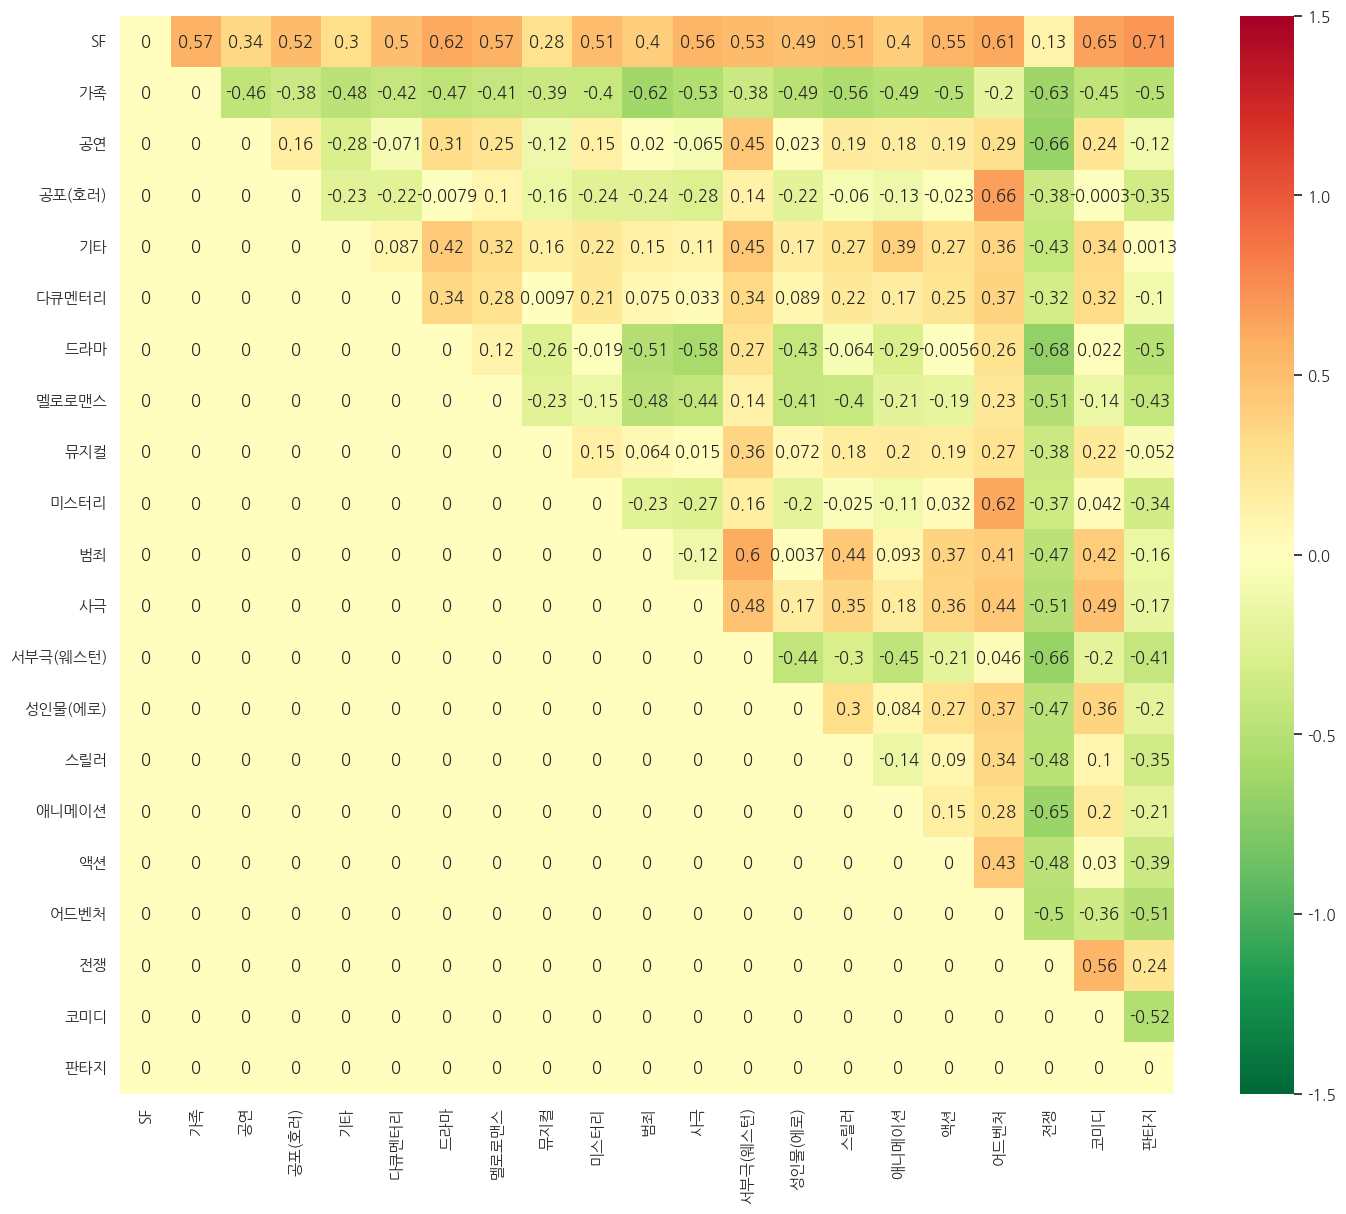

In [50]:
import numpy as np;
import seaborn as sns;

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호
plt.figure(figsize=(17, 14))   # Heatmap 전체 크기 조절 (가로, 세로 인치)
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(
    matrix,
    xticklabels=genre_name,
    yticklabels=genre_name,
    annot=True,
    cmap='RdYlGn_r',
    vmin=-1.5,
    vmax=1.5,
    center=0
)
ax

<Axes: >

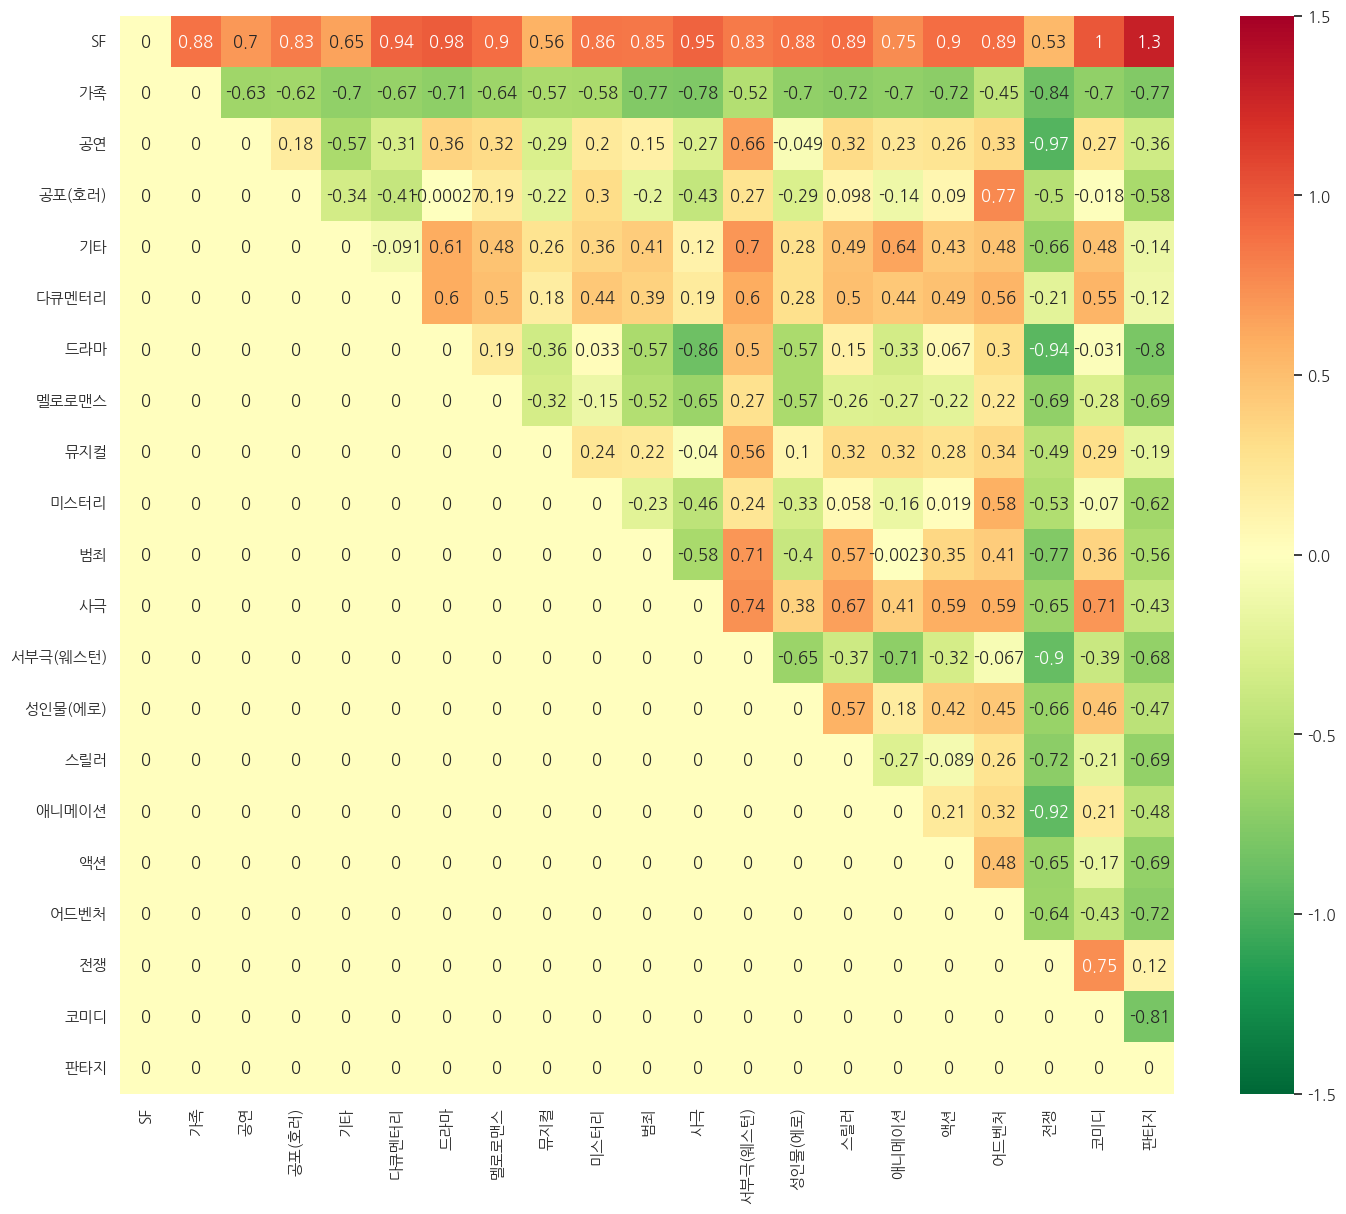

In [51]:
import numpy as np;
import seaborn as sns;

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호
plt.figure(figsize=(17, 14))   # Heatmap 전체 크기 조절 (가로, 세로 인치)
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(
    matrix_no_rep,
    xticklabels=genre_name,
    yticklabels=genre_name,
    annot=True,
    cmap='RdYlGn_r',
    vmin=-1.5,
    vmax=1.5,
    center=0
)
ax

#### **결과 고찰**
- 값의 절댓값 분포가 커졌다
  - 0 근처의 연한 색이 줄고 강한 빨강/초록(큰 양수·음수)이 늘어남
  - 개념 축이 더 또렷하게 형성되었다는 뜻
- 대비(contrast)가 증가했다
  - 어떤 조합은 빨강, 어떤 조합은 초록으로 명확히 갈라짐
  - 장르 간 의미적 방향 차이가 더 뚜렷해졌다는 증거. 즉 모호한 관계가 줄고 분명한 관계가 늘어남
